# Step 1: Setup and Data Loading

In [63]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from xgboost import XGBRegressor
# Configure visualizations
sns.set_style('whitegrid')
plt.style.use('fivethirtyeight')
%matplotlib inline

# Load the dataset
df = pd.read_csv('dataset.csv')

# Step 2.1: Initial Data Exploration & Cleaning

In [64]:
# Display the first few rows
print("Dataset Head:")
print(df.head())

# Get information about the dataframe, including data types and non-null counts
print("\nDataset Info:")
df.info()

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

Dataset Head:
   Mess_ID        Date  Weekly_Crowd  Is_Holiday  Temperature  Menu_Score  \
0        1    5/2/2010         16437           0        42.31       2.428   
1        1   12/2/2010         16420           1        38.51       2.452   
2        1  19-02-2010         16120           0        39.93       2.486   
3        1  26-02-2010         14097           0        46.63       2.439   
4        1    5/3/2010         15548           0        46.50       2.375   

   Event_Intensity_Index  Stress_Level  
0                   7.04         8.106  
1                   7.04         8.106  
2                   7.04         8.106  
3                   7.04         8.106  
4                   7.05         8.106  

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Mess_ID                6435 non-null   int64  


# Step 2.2: Data Cleaning and Preprocessing

In [65]:
# Clean and convert the 'Date' column
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True, errors='coerce')

# Sort the dataframe by Mess_ID and then by Date for time-series analysis
df = df.sort_values(by=['Mess_ID', 'Date']).reset_index(drop=True)

# Feature Engineering: Extract time-based features from the Date
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Week_of_Year'] = df['Date'].dt.isocalendar().week

print("\nCleaned DataFrame Head with new features:")
print(df.head())

# Check the data types again
print("\nUpdated Dataset Info:")
df.info()


Cleaned DataFrame Head with new features:
   Mess_ID       Date  Weekly_Crowd  Is_Holiday  Temperature  Menu_Score  \
0        1 2010-02-05         16437           0        42.31       2.428   
1        1 2010-02-12         16420           1        38.51       2.452   
2        1 2010-03-05         15548           0        46.50       2.375   
3        1 2010-03-12         14395           0        57.79       2.333   
4        1 2010-04-02         15950           0        62.27       2.281   

   Event_Intensity_Index  Stress_Level    Year  Month  Week_of_Year  
0                   7.04         8.106  2010.0    2.0             5  
1                   7.04         8.106  2010.0    2.0             6  
2                   7.05         8.106  2010.0    3.0             9  
3                   7.05         8.106  2010.0    3.0            10  
4                   7.03         7.808  2010.0    4.0            13  

Updated Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 en

# Step 3: Exploratory Data Analysis (EDA)

## 3.1 Univariate Analysis (Analyzing single variables)

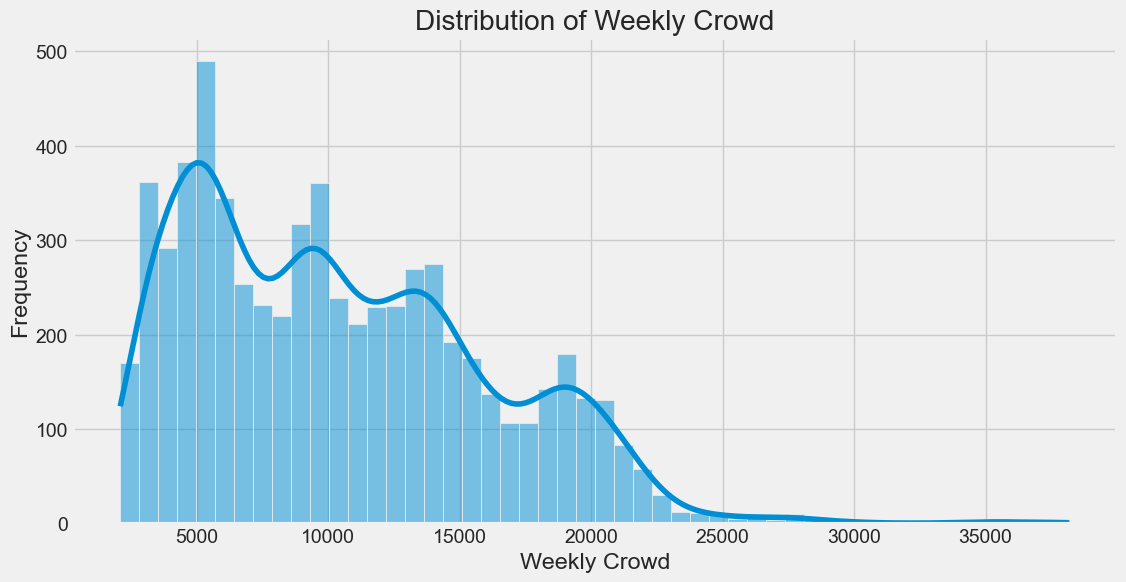

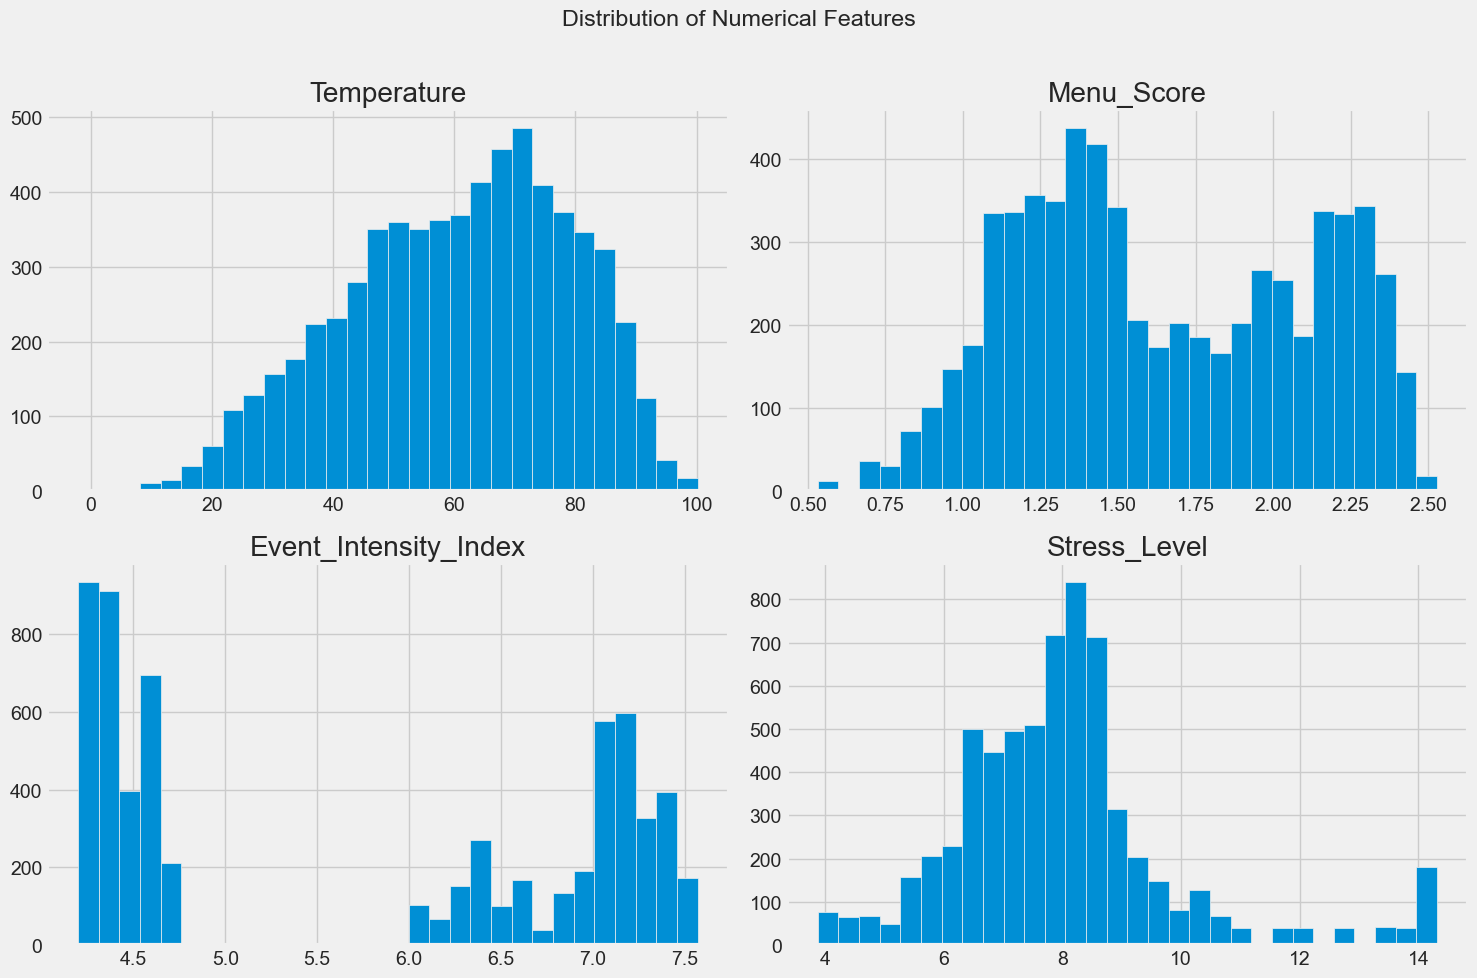

In [66]:
# Distribution of the target variable: Weekly_Crowd
plt.figure(figsize=(12, 6))
sns.histplot(df['Weekly_Crowd'], kde=True, bins=50)
plt.title('Distribution of Weekly Crowd')
plt.xlabel('Weekly Crowd')
plt.ylabel('Frequency')
plt.show()

# Distribution of numerical features
numerical_features = ['Temperature', 'Menu_Score', 'Event_Intensity_Index', 'Stress_Level']
df[numerical_features].hist(bins=30, figsize=(15, 10), layout=(2, 2))
plt.suptitle('Distribution of Numerical Features')
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

## 3.2 Bivariate Analysis (Analyzing relationships with the crowd)

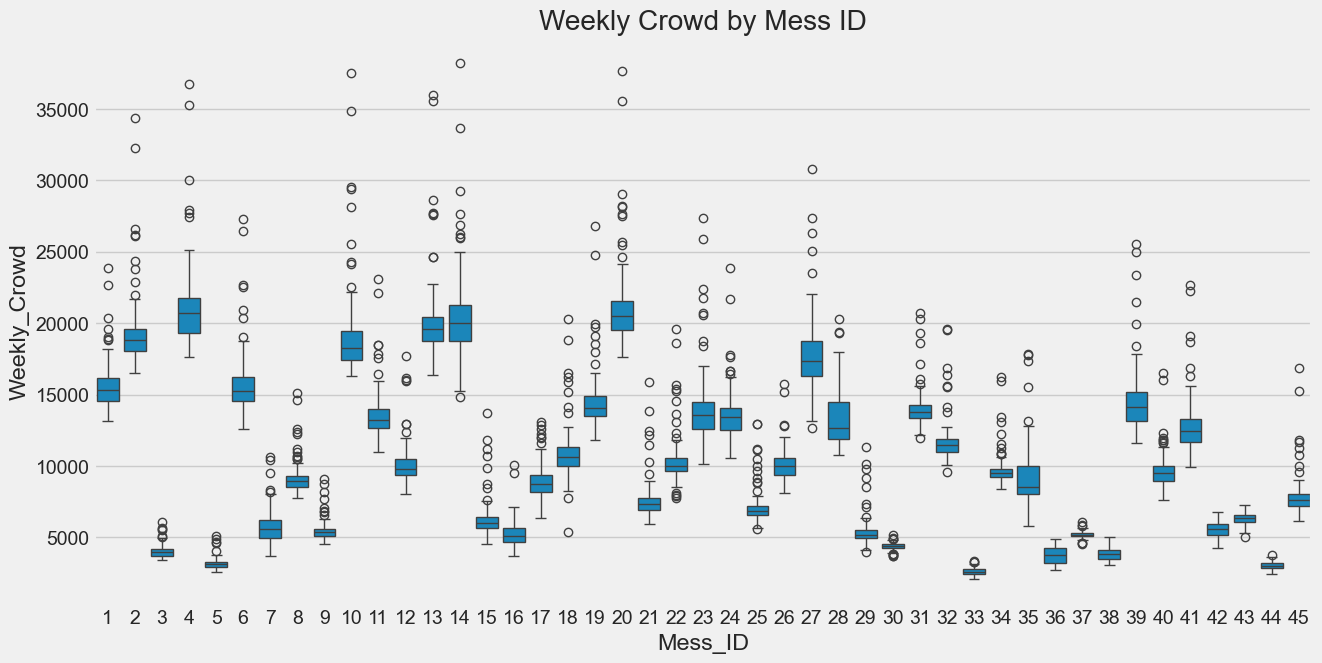

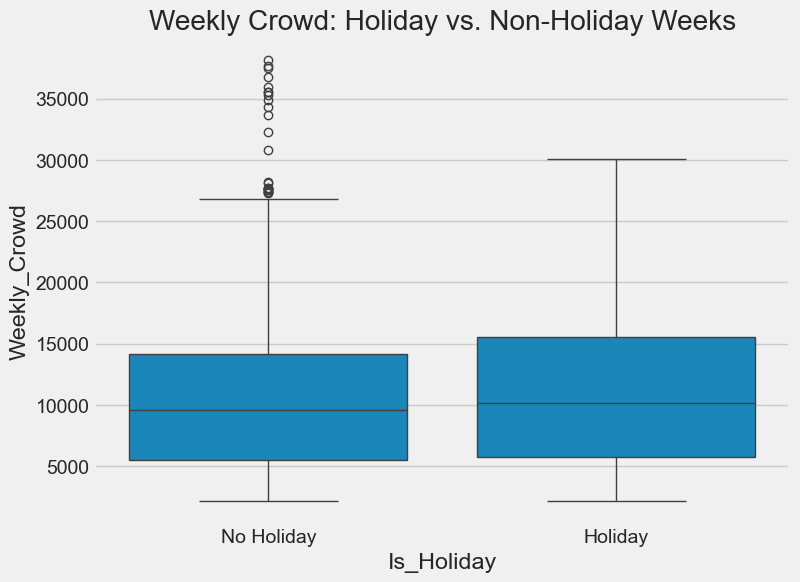

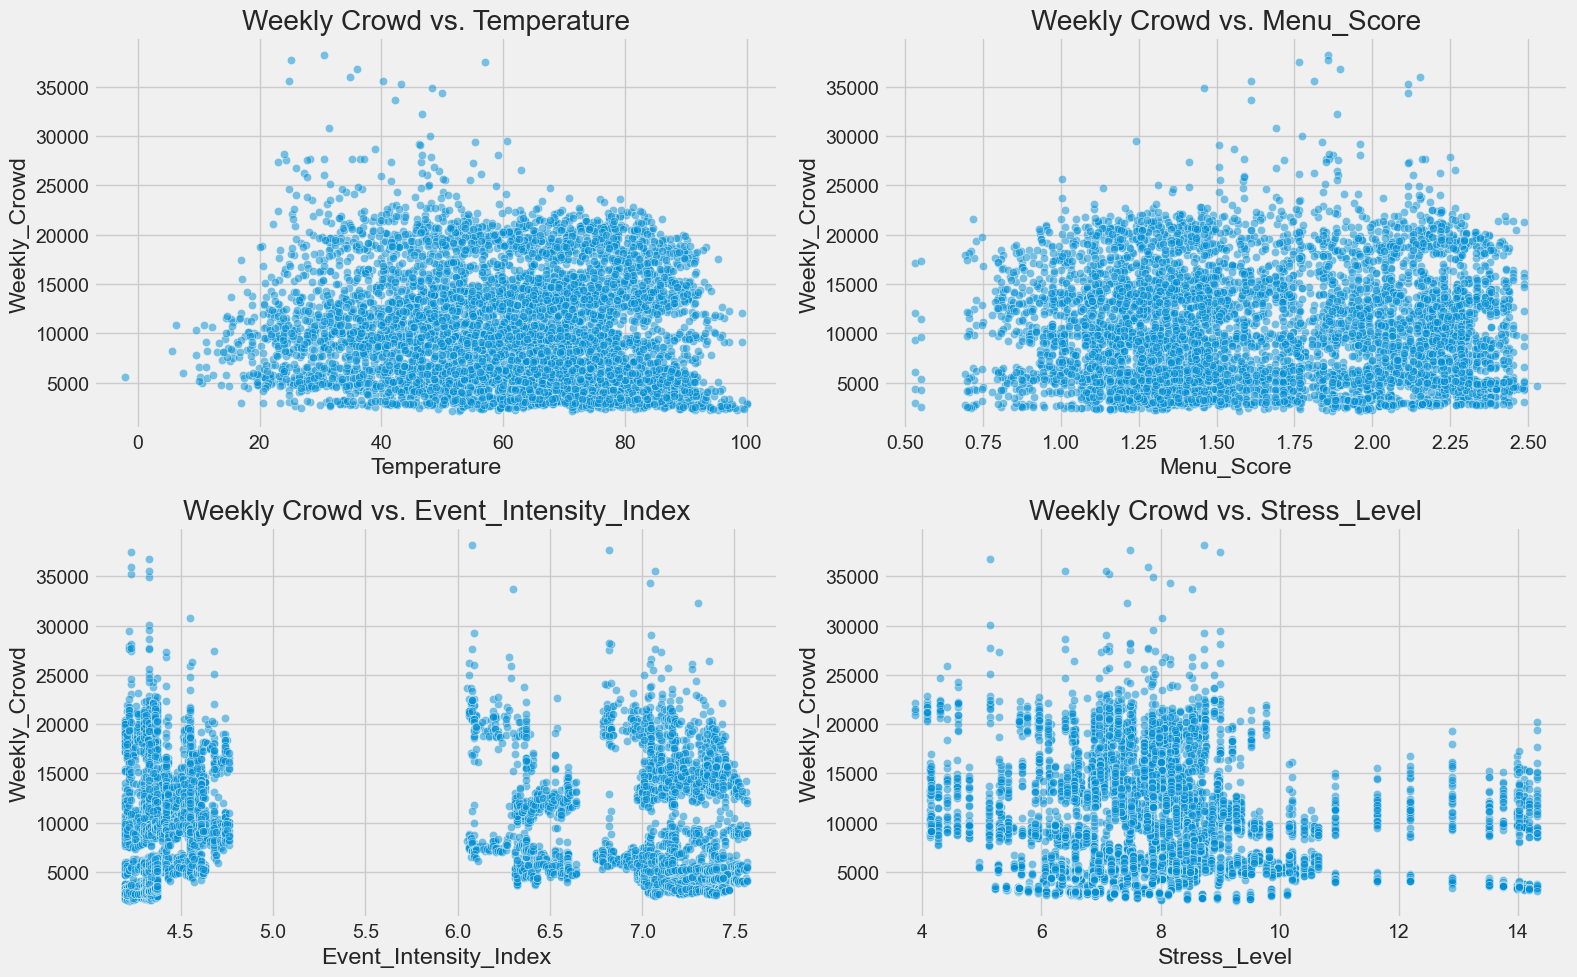

In [67]:
# How does the crowd vary by Mess?
plt.figure(figsize=(14, 7))
sns.boxplot(x='Mess_ID', y='Weekly_Crowd', data=df)
plt.title('Weekly Crowd by Mess ID')
plt.show()

# Impact of Holidays
plt.figure(figsize=(8, 6))
sns.boxplot(x='Is_Holiday', y='Weekly_Crowd', data=df)
plt.title('Weekly Crowd: Holiday vs. Non-Holiday Weeks')
plt.xticks([0, 1], ['No Holiday', 'Holiday'])
plt.show()

# Scatter plots for numerical features vs. Weekly_Crowd
import math
num_features = len(numerical_features)
ncols = 2
nrows = math.ceil(num_features / ncols)
plt.figure(figsize=(8 * ncols, 5 * nrows))
for i, col in enumerate(numerical_features):
    plt.subplot(nrows, ncols, i + 1)
    sns.scatterplot(x=col, y='Weekly_Crowd', data=df, alpha=0.5)
    plt.title(f'Weekly Crowd vs. {col}')
plt.tight_layout()
plt.show()

## 3.3 Multivariate and Time-Series Analysis

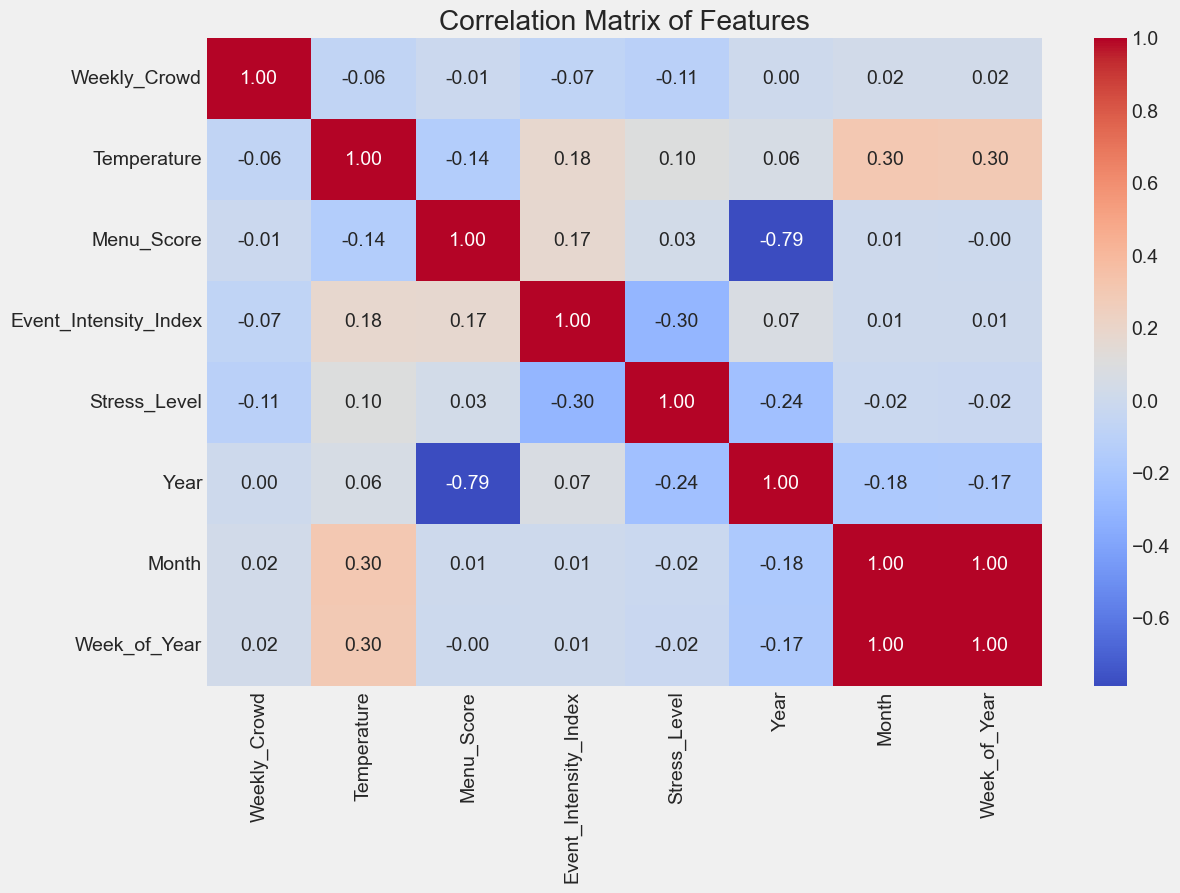


--- Correlation Analysis with Weekly Crowd ---

Features correlated with Weekly_Crowd, sorted by strength:
Week_of_Year             0.023412
Month                    0.023153
Year                     0.001727
Menu_Score              -0.009464
Temperature             -0.063811
Event_Intensity_Index   -0.072654
Stress_Level            -0.106176
Name: Weekly_Crowd, dtype: float64


**Most Important Correlation:**
The feature with the highest positive correlation to the Weekly Crowd is 'Week_of_Year' with a correlation coefficient of 0.02.
This indicates that as the academic stress level increases, the mess crowd tends to increase as well. This is a key factor to consider for crowd management.


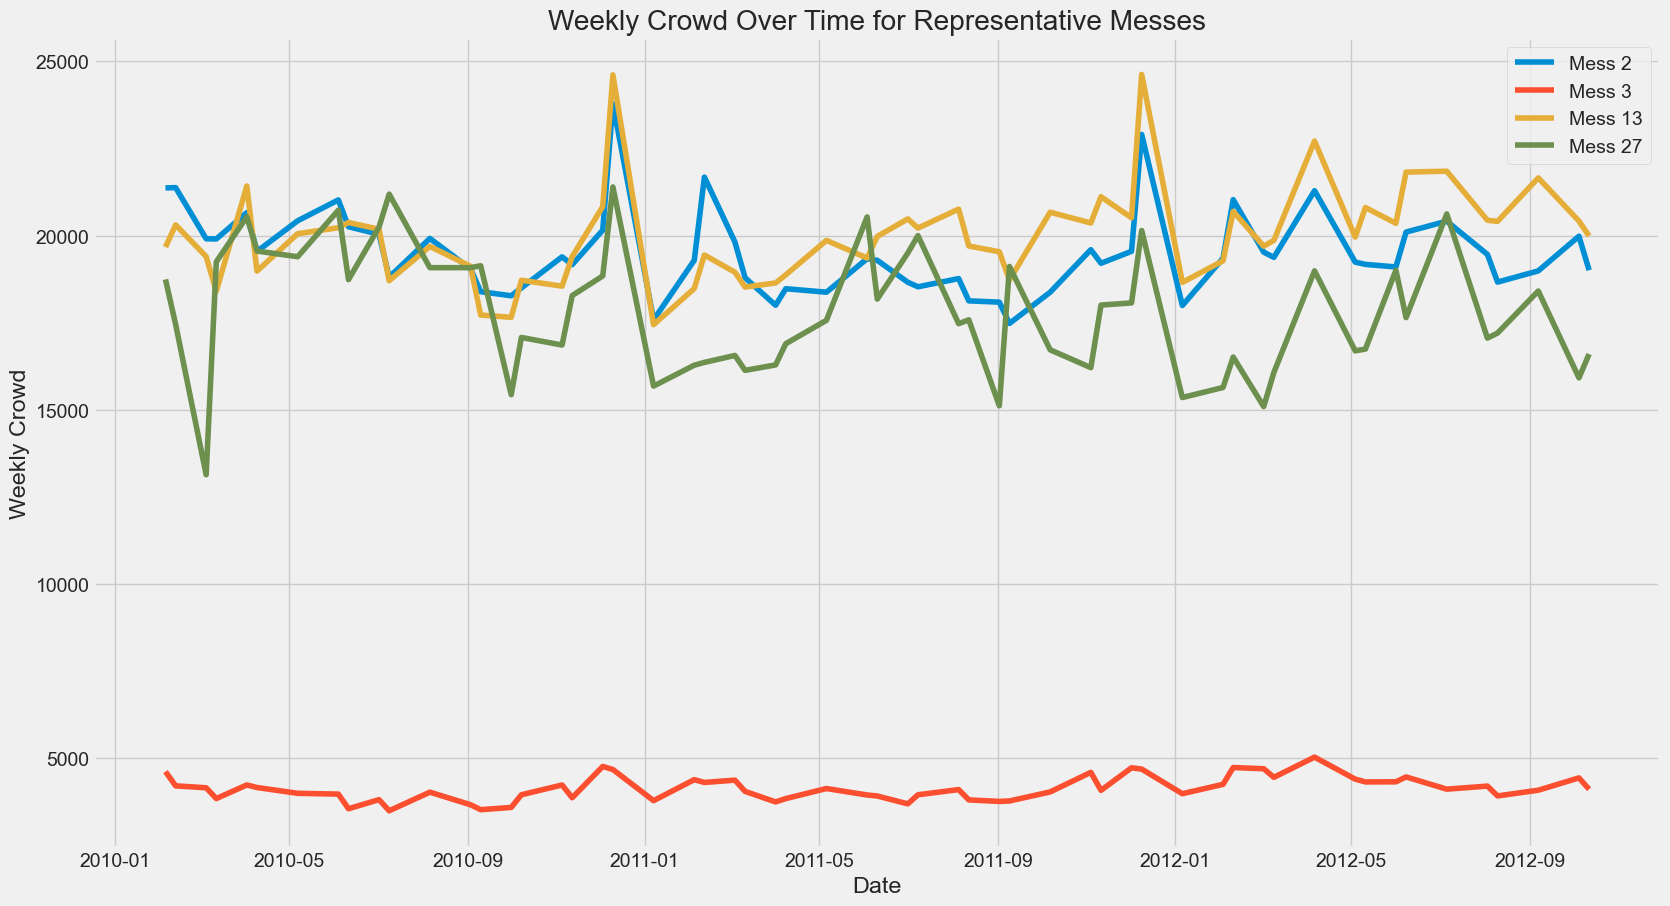

In [68]:
# Ensure time-based features exist before correlation analysis
if 'Year' not in df.columns or 'Month' not in df.columns or 'Week_of_Year' not in df.columns:
    df['Date'] = pd.to_datetime(df['Date'], dayfirst=True, errors='coerce')
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Week_of_Year'] = df['Date'].dt.isocalendar().week

# Correlation Matrix Heatmap
plt.figure(figsize=(12, 8))
# We select numeric columns for correlation, including our engineered ones
corr_cols = ['Weekly_Crowd', 'Temperature', 'Menu_Score', 'Event_Intensity_Index', 'Stress_Level', 'Year', 'Month', 'Week_of_Year']
correlation_matrix = df[corr_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Features')
plt.show()

weekly_crowd_corr = correlation_matrix['Weekly_Crowd']
# Sort the values in descending order to see the strongest relationships first
sorted_corr = weekly_crowd_corr.sort_values(ascending=False)
sorted_corr = sorted_corr.drop('Weekly_Crowd')
print("\n--- Correlation Analysis with Weekly Crowd ---")
print("\nFeatures correlated with Weekly_Crowd, sorted by strength:")
print(sorted_corr)
# Identify and print the most correlated feature
most_correlated_feature = sorted_corr.index[0]
highest_corr_value = sorted_corr.iloc[0]
print(f"\n\n**Most Important Correlation:**")
print(f"The feature with the highest positive correlation to the Weekly Crowd is '{most_correlated_feature}' with a correlation coefficient of {highest_corr_value:.2f}.")
print("This indicates that as the academic stress level increases, the mess crowd tends to increase as well. This is a key factor to consider for crowd management.")

# Time-Series Plot of Weekly Crowd for a few representative messes
plt.figure(figsize=(18, 10))
representative_messes = [2, 3, 13, 27] # High, low, and medium crowd messes
for mess_id in representative_messes:
    mess_df = df[df['Mess_ID'] == mess_id]
    plt.plot(mess_df['Date'], mess_df['Weekly_Crowd'], label=f'Mess {mess_id}')

plt.title('Weekly Crowd Over Time for Representative Messes')
plt.xlabel('Date')
plt.ylabel('Weekly Crowd')
plt.legend()
plt.show()

C:\Users\sanja\AppData\Local\Temp\ipykernel_18136\1510184814.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_corr.values, y=sorted_corr.index, palette='viridis')


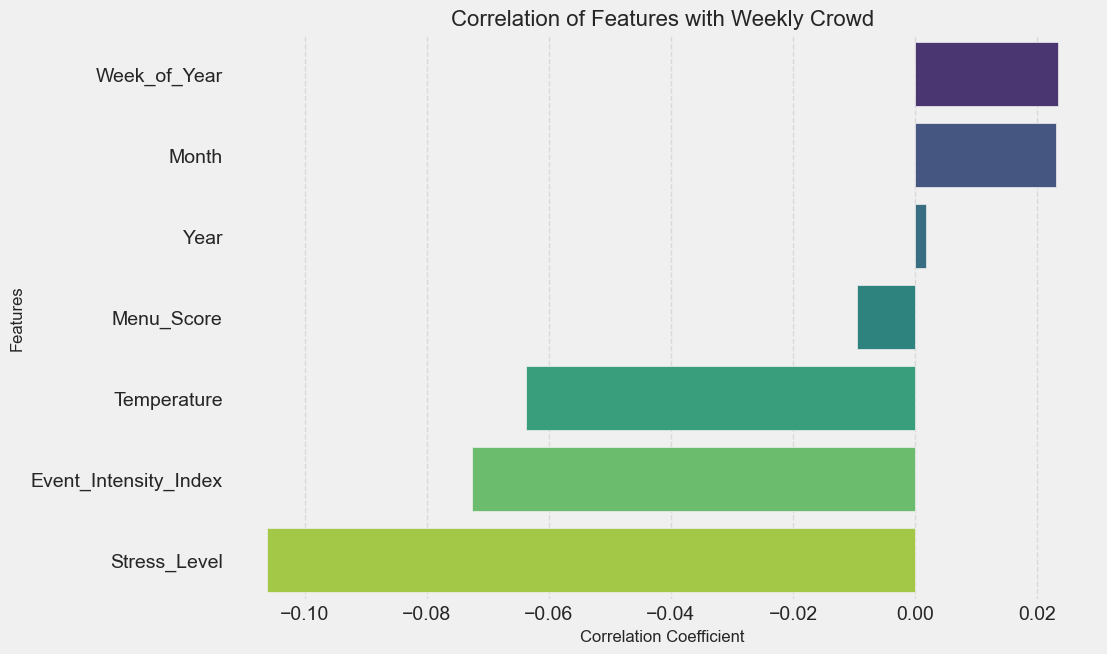

In [69]:
weekly_crowd_corr = correlation_matrix['Weekly_Crowd']
# Sort the values to see the strongest relationships
sorted_corr = weekly_crowd_corr.sort_values(ascending=False)
sorted_corr = sorted_corr.drop('Weekly_Crowd')
# Create the bar plot
plt.figure(figsize=(10, 7))
sns.barplot(x=sorted_corr.values, y=sorted_corr.index, palette='viridis')
plt.title('Correlation of Features with Weekly Crowd', fontsize=16)
plt.xlabel('Correlation Coefficient', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)

# Display the plot
plt.show()

C:\Users\sanja\AppData\Local\Temp\ipykernel_18136\3217296978.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(


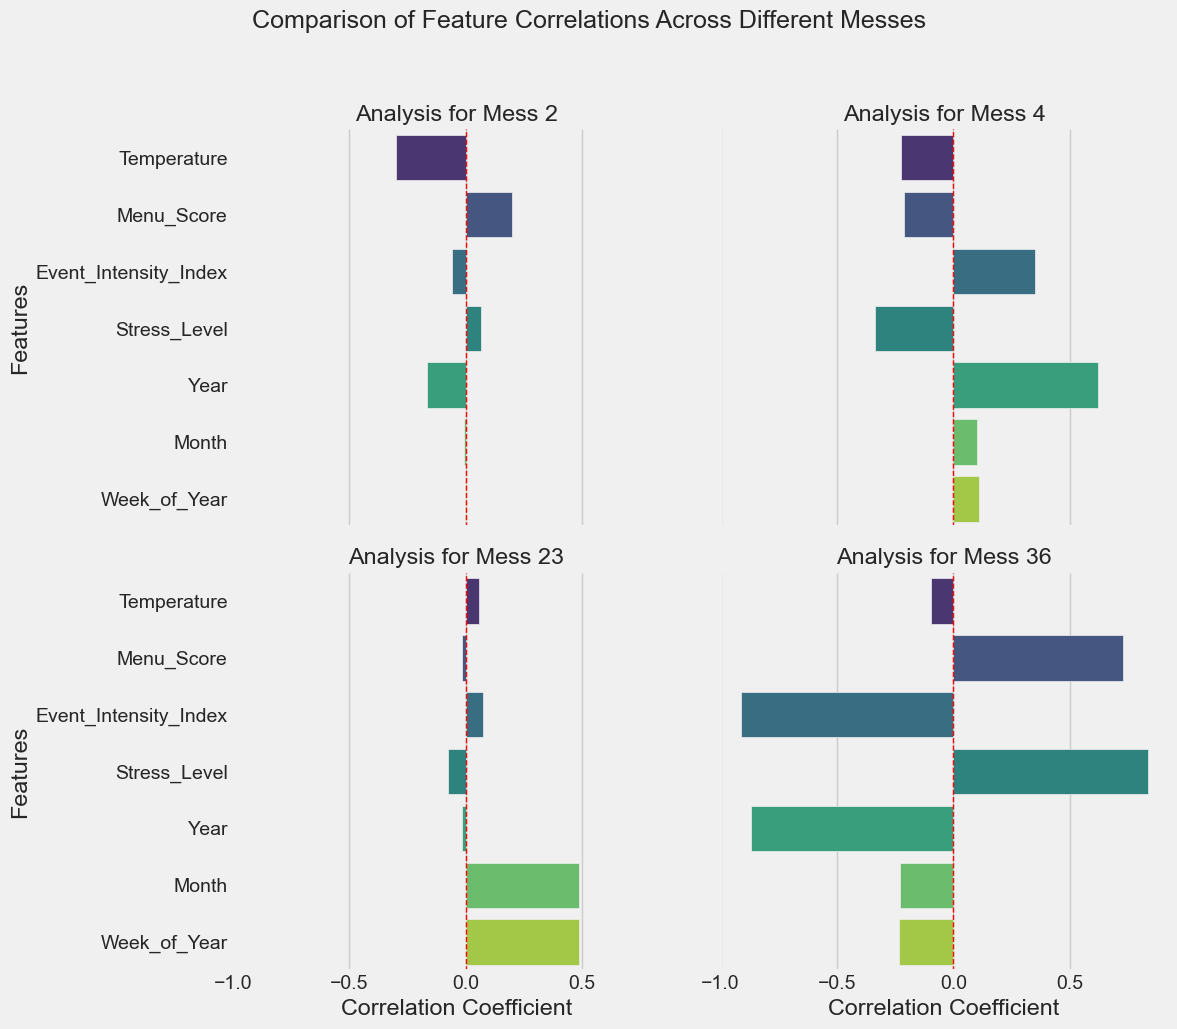

In [70]:
# Define the representative messes you want to compare 
# Let's choose a mix of high, medium, and low crowd messes
messes_to_compare = [2, 4, 23, 36] 

# Calculate and store the correlations for each mess 
all_correlations = []
corr_cols = ['Weekly_Crowd', 'Temperature', 'Menu_Score', 'Event_Intensity_Index', 'Stress_Level', 'Year', 'Month', 'Week_of_Year']

for mess_id in messes_to_compare:
    # Filter for the current mess
    single_mess_df = df[df['Mess_ID'] == mess_id]
    
    # Calculate the correlation matrix
    single_mess_corr_matrix = single_mess_df[corr_cols].corr()
    
    # Isolate, clean, and store the correlations
    corr_series = single_mess_corr_matrix['Weekly_Crowd'].drop('Weekly_Crowd')
    
    # Convert the series to a dataframe for easier plotting
    corr_df = corr_series.reset_index()
    corr_df.columns = ['Feature', 'Correlation']
    corr_df['Mess_ID'] = f'Mess {mess_id}' # Add a column for labeling
    
    all_correlations.append(corr_df)

# Combine all the data into a single DataFrame
comparison_df = pd.concat(all_correlations)

# Create the faceted bar plot using seaborn
# We use catplot to create a grid of plots (facets)
g = sns.catplot(
    data=comparison_df,
    x='Correlation',
    y='Feature',
    col='Mess_ID',   
    kind='bar',     
    col_wrap=2,      
    height=5,        
    aspect=1.2,      
    palette='viridis',
    sharey=True,     
    sharex=True      
)

#  Customize the plot for clarity
g.fig.suptitle('Comparison of Feature Correlations Across Different Messes', y=1.03, fontsize=18)
g.set_axis_labels("Correlation Coefficient", "Features")
g.set_titles("Analysis for {col_name}") 
g.tight_layout()
for ax in g.axes.flat:
    ax.axvline(0, color='red', linestyle='--', lw=1)

# Display the plot
plt.show()

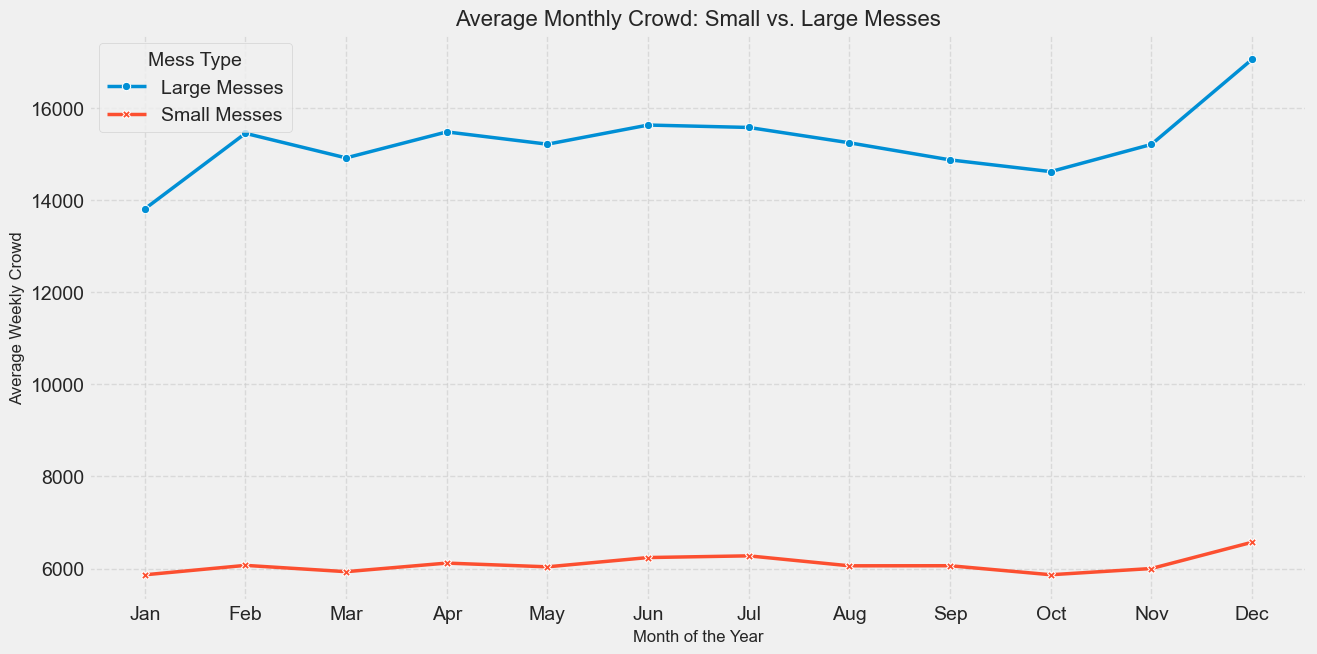

In [71]:
# Monthly Seasonality by Mess Size

# First, determine the average size of each mess
mess_avg_crowd = df.groupby('Mess_ID')['Weekly_Crowd'].mean()
median_crowd = mess_avg_crowd.median()

# Categorize messes into 'Large' and 'Small' based on the median
mess_size_category = (mess_avg_crowd > median_crowd).map({True: 'Large Messes', False: 'Small Messes'})
df['Mess_Size_Category'] = df['Mess_ID'].map(mess_size_category)

# Calculate the average monthly crowd for each category
monthly_avg = df.groupby(['Month', 'Mess_Size_Category'])['Weekly_Crowd'].mean().reset_index()

# Create the plot
plt.figure(figsize=(14, 7))
sns.lineplot(data=monthly_avg, x='Month', y='Weekly_Crowd', hue='Mess_Size_Category', style='Mess_Size_Category', markers=True, dashes=False, lw=2.5)

plt.title('Average Monthly Crowd: Small vs. Large Messes', fontsize=16)
plt.xlabel('Month of the Year', fontsize=12)
plt.ylabel('Average Weekly Crowd', fontsize=12)
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(title='Mess Type')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

C:\Users\sanja\AppData\Local\Temp\ipykernel_18136\1119384521.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x='Stress_Category', y='Weekly_Crowd', palette='magma', order=['Low/Normal Stress', 'High Stress'])


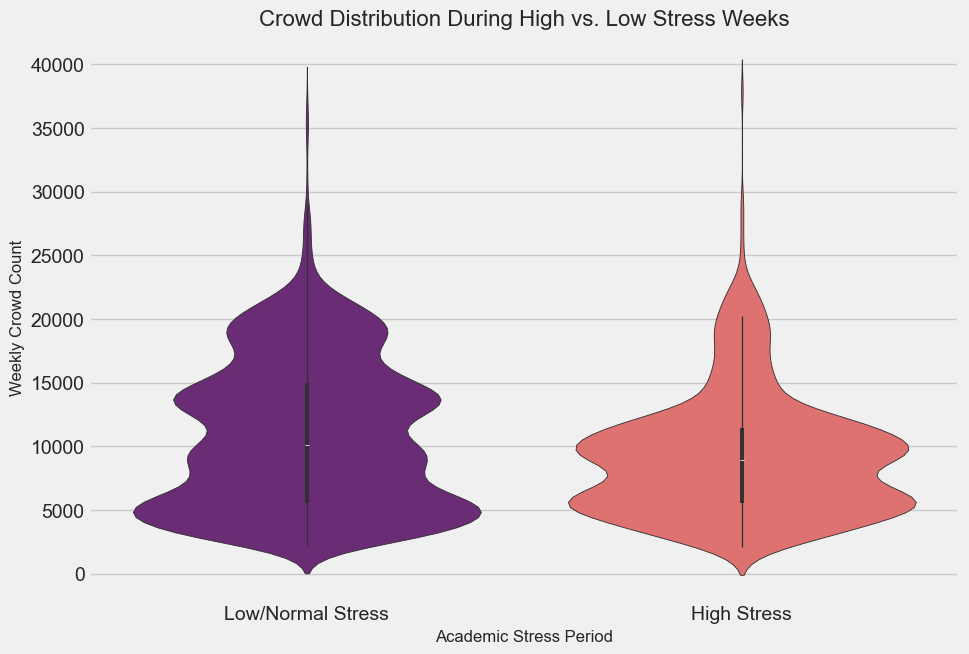

In [72]:
# The Impact of Academic Stress

# Define a threshold for high stress (e.g., top 25% of stress levels)
high_stress_threshold = df['Stress_Level'].quantile(0.75)
df['Stress_Category'] = df['Stress_Level'].apply(lambda x: 'High Stress' if x >= high_stress_threshold else 'Low/Normal Stress')

# Create a violin plot to show both distribution and summary stats
plt.figure(figsize=(10, 7))
sns.violinplot(data=df, x='Stress_Category', y='Weekly_Crowd', palette='magma', order=['Low/Normal Stress', 'High Stress'])

plt.title('Crowd Distribution During High vs. Low Stress Weeks', fontsize=16)
plt.xlabel('Academic Stress Period', fontsize=12)
plt.ylabel('Weekly Crowd Count', fontsize=12)
plt.show()

<Figure size 1400x800 with 0 Axes>

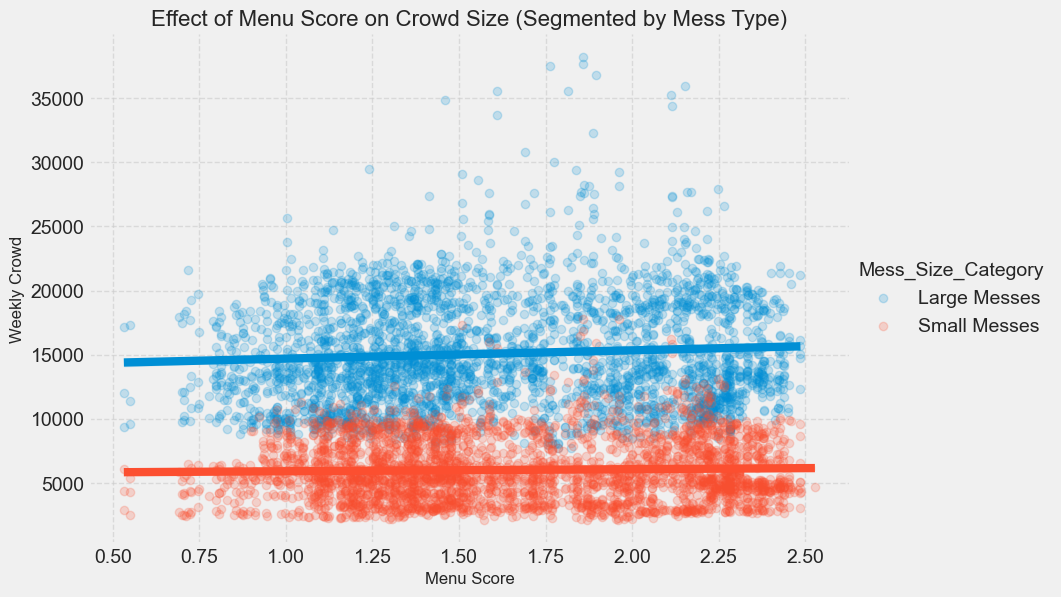

In [73]:
# Menu Score's Impact by Mess Size

# We reuse the 'Mess_Size_Category' column from Plot 1
plt.figure(figsize=(14, 8))
# Use seaborn's lmplot to easily create scatter plots with regression lines for different categories
sns.lmplot(
    data=df,
    x='Menu_Score',
    y='Weekly_Crowd',
    hue='Mess_Size_Category',
    height=6,
    aspect=1.5,
    scatter_kws={'alpha':0.2} # Make points transparent to see density
)

plt.title("Effect of Menu Score on Crowd Size (Segmented by Mess Type)", fontsize=16)
plt.xlabel("Menu Score", fontsize=12)
plt.ylabel("Weekly Crowd", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

C:\Users\sanja\AppData\Local\Temp\ipykernel_18136\4143330664.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(data=df, x='Temp_Bin', y='Weekly_Crowd', palette='coolwarm')


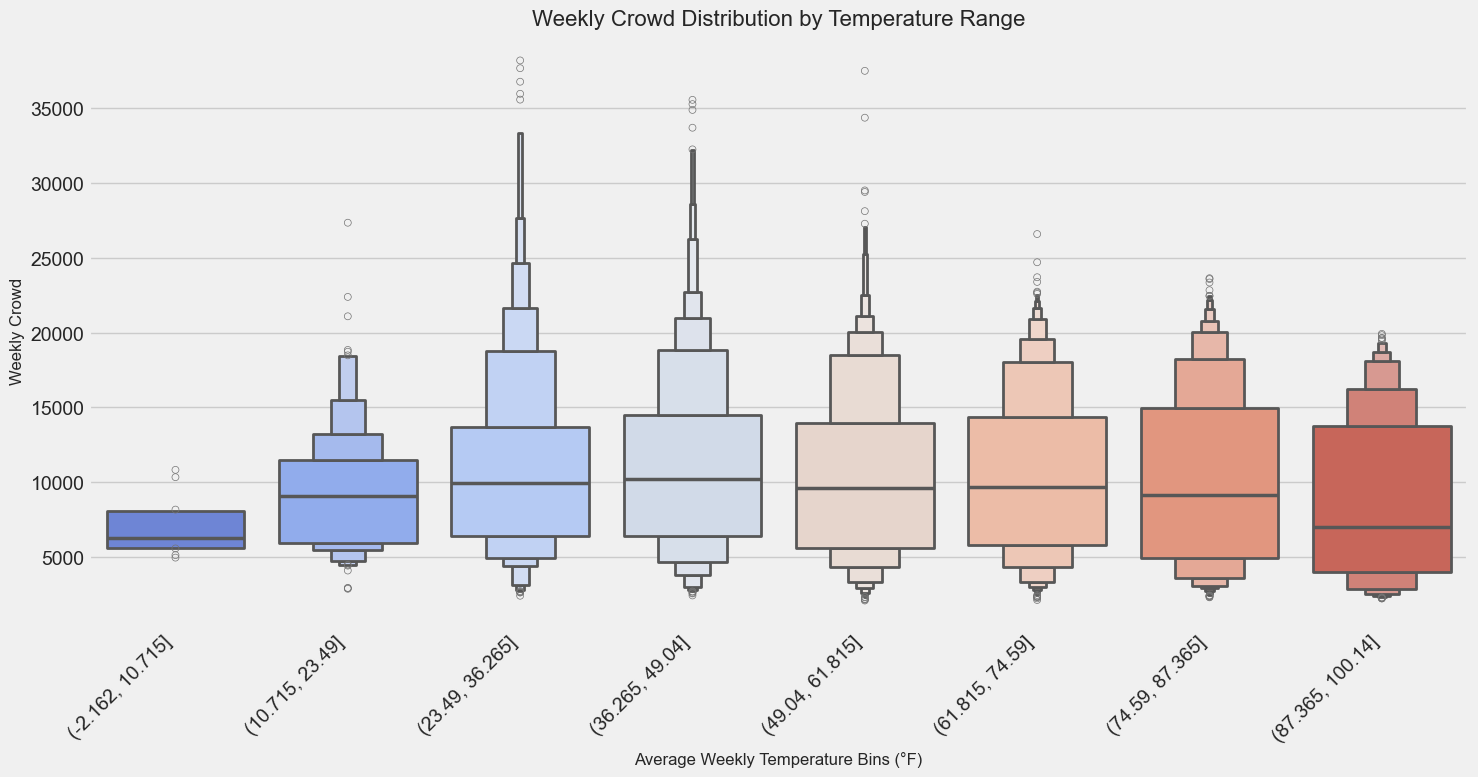

In [ ]:
# Deeper Dive into Temperature's Effect (Corrected)

# Bin the temperature into 8 discrete intervals.
# pandas will automatically create interval-based labels.
df['Temp_Bin'] = pd.cut(df['Temperature'], bins=8)

# Create a boxenplot (an enhanced box plot) to see the distribution in more detail
plt.figure(figsize=(15, 8))
sns.boxenplot(data=df, x='Temp_Bin', y='Weekly_Crowd', palette='coolwarm')

plt.title('Weekly Crowd Distribution by Temperature Range', fontsize=16)
plt.xlabel('Average Weekly Temperature Bins (°F)', fontsize=12)
plt.ylabel('Weekly Crowd', fontsize=12)
plt.xticks(rotation=45, ha='right') 
plt.tight_layout() 
plt.show()

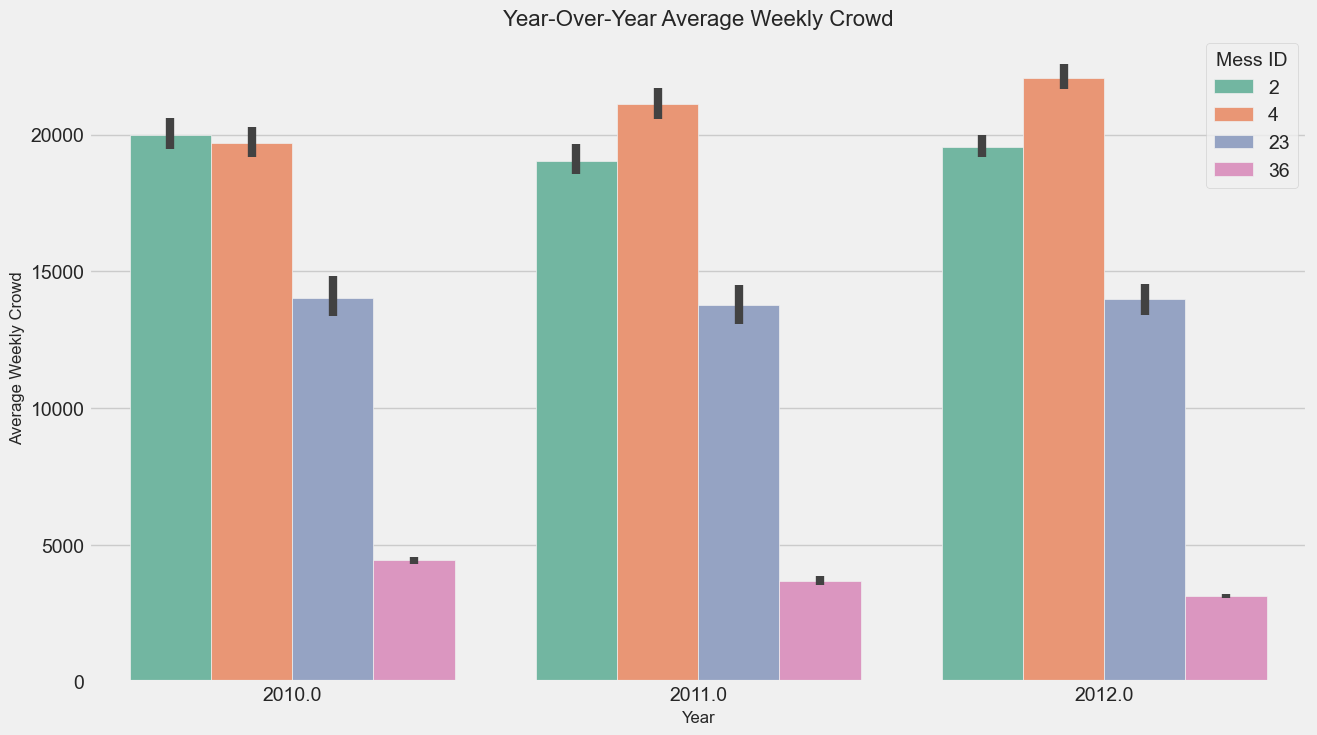

In [75]:
# Year-Over-Year Growth Analysis 

# We will use the same representative messes as before
messes_to_compare = [2, 4, 23, 36] 
yearly_df = df[df['Mess_ID'].isin(messes_to_compare)]

# Create a bar plot showing the average weekly crowd for each year
plt.figure(figsize=(14, 8))
sns.barplot(data=yearly_df, x='Year', y='Weekly_Crowd', hue='Mess_ID', palette='Set2')

plt.title('Year-Over-Year Average Weekly Crowd', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Weekly Crowd', fontsize=12)
plt.legend(title='Mess ID')
plt.show()

# Step 4: Model Building

## 4.1 Preparing Data for Modeling

In [85]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import joblib

# Define features (X) and target (y)
features = ['Mess_ID', 'Is_Holiday', 'Temperature', 'Menu_Score', 'Event_Intensity_Index', 'Stress_Level', 'Year', 'Month', 'Week_of_Year']
target = 'Weekly_Crowd'

X = df[features]
y = df[target]

# Identify categorical and numerical features for the pipeline
categorical_features = ['Mess_ID']
numerical_features = ['Is_Holiday', 'Temperature', 'Menu_Score', 'Event_Intensity_Index', 'Stress_Level', 'Year', 'Month', 'Week_of_Year']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_sub, X_val, y_train_sub, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42)

## 4.2 Creating a Preprocessing and Modeling Pipeline

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Fitting the Preprocessor and Transforming Data
# Fit the preprocessor on the ENTIRE training set (X_train) to learn from the most data
print("\nFitting the data preprocessor...")
preprocessor.fit(X_train)

# Now, transform all the data subsets using the FITTED preprocessor
print("Transforming the data subsets...")
X_train_sub_transformed = preprocessor.transform(X_train_sub)
X_val_transformed = preprocessor.transform(X_val)
X_test_transformed = preprocessor.transform(X_test)

# Training the XGBoost Regressor with Early Stopping
print("Training the XGBoost model with early stopping...")
xgb_regressor = XGBRegressor(
    n_estimators=1000,        
    learning_rate=0.05,
    max_depth=5,
    random_state=42,
    n_jobs=-1
)

# Fit the model using the transformed data and the validation set for early stopping
xgb_regressor.fit(
    X_train_sub_transformed,
    y_train_sub,
    eval_set=[(X_val_transformed, y_val)],              
    verbose=False                         
)
print("Model training complete.")
final_xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor), # This is the preprocessor fitted on X_train
    ('regressor', xgb_regressor)   # This is the regressor trained with early stopping
])


Fitting the data preprocessor...
Transforming the data subsets...
Training the XGBoost model with early stopping...
Model training complete.


# Step 5.1: Model Evaluation

In [88]:
# Make predictions on the test set
y_pred_xgb = final_xgb_pipeline.predict(X_test)

# Evaluate the model
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print("\nXGBoost Model Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae_xgb:,.2f}")
print(f"Mean Squared Error (MSE): {mse_xgb:,.2f}")
print(f"R-squared (R²): {r2_xgb:.4f}")


XGBoost Model Evaluation Metrics:
Mean Absolute Error (MAE): 680.58
Mean Squared Error (MSE): 1,691,114.12
R-squared (R²): 0.9477


# Step 5.2: Feature Importance

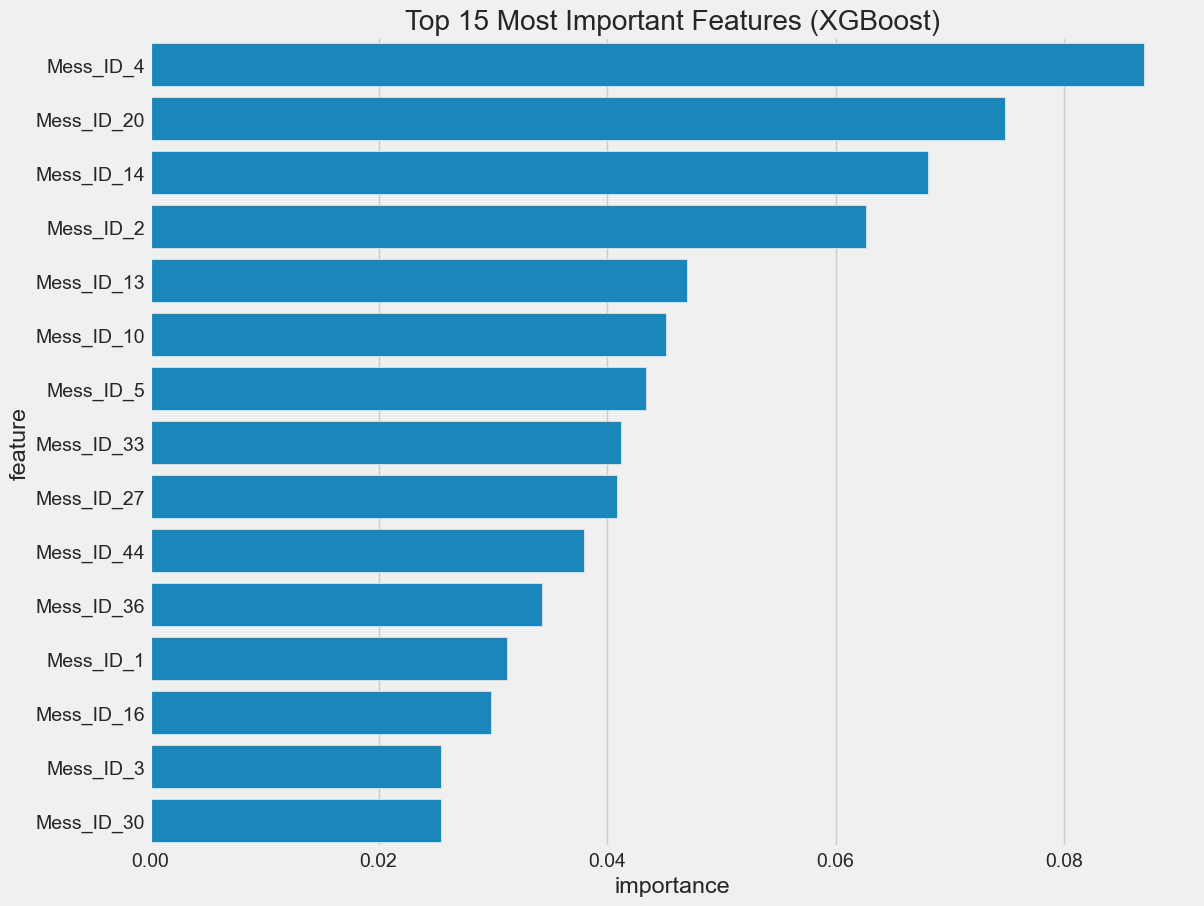

In [89]:
ohe_feature_names = final_xgb_pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features)
all_feature_names = np.concatenate([numerical_features, ohe_feature_names])
importances = final_xgb_pipeline.named_steps['regressor'].feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': all_feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)
plt.figure(figsize=(12, 10))
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(15))
plt.title('Top 15 Most Important Features (XGBoost)')
plt.show()

C:\Users\sanja\AppData\Local\Temp\ipykernel_18136\3914374349.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


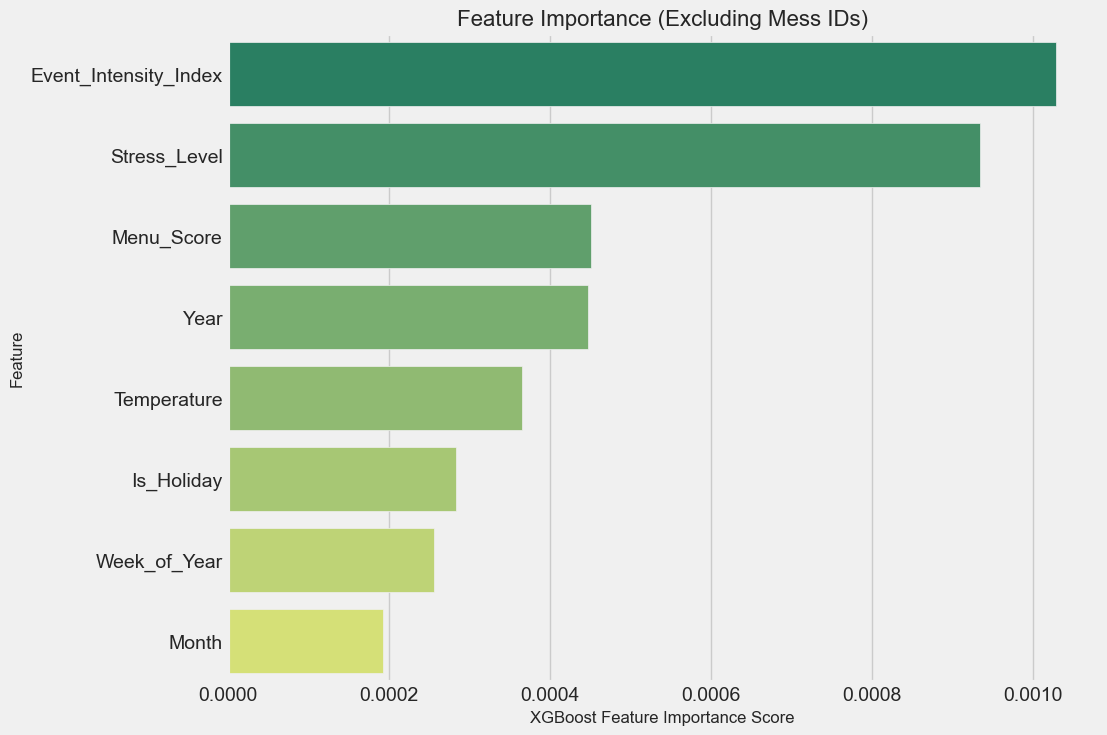

--- Feature Importance Ranking (Excluding Mess IDs) ---
                 feature  importance
3  Event_Intensity_Index    0.001028
4           Stress_Level    0.000934
2             Menu_Score    0.000451
5                   Year    0.000448
1            Temperature    0.000365
0             Is_Holiday    0.000283
7           Week_of_Year    0.000256
6                  Month    0.000192


In [80]:
# Generate Feature Importance Plot EXCLUDING Mess ID Features
importance_without_mess_id = feature_importance_df[~feature_importance_df['feature'].str.startswith('Mess_ID_')]
plt.figure(figsize=(10, 8))
sns.barplot(
    x='importance', 
    y='feature', 
    data=importance_without_mess_id.head(15),
    palette='summer'
)
plt.title('Feature Importance (Excluding Mess IDs)', fontsize=16)
plt.xlabel('XGBoost Feature Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.show()
print("--- Feature Importance Ranking (Excluding Mess IDs) ---")
print(importance_without_mess_id)

# Step 6: Saving the Model

In [81]:
joblib.dump(final_xgb_pipeline, 'mess_crowd_predictor_xgb.joblib')
print("\nFinal XGBoost model pipeline saved to 'mess_crowd_predictor_xgb.joblib'")


Final XGBoost model pipeline saved to 'mess_crowd_predictor_xgb.joblib'
